### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from scipy.stats import skew
from sklearn.linear_model import LinearRegression, ElasticNet, RANSACRegressor
from sklearn.model_selection import learning_curve, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

/home/adam/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Loading data

In [2]:
df_train = pd.read_csv('train.csv')
df_test= pd.read_csv('test.csv')

### First overview of the data

In [3]:
#df_train.SalePrice.describe()

In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


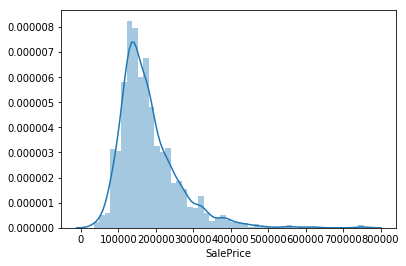

In [5]:
sns.distplot(df_train.SalePrice)

In [6]:
print("Skewness: %f" % df_train.SalePrice.skew())

print("Kurtosis: %f" % df_train.SalePrice.kurt())

Skewness: 1.882876
Kurtosis: 6.536282


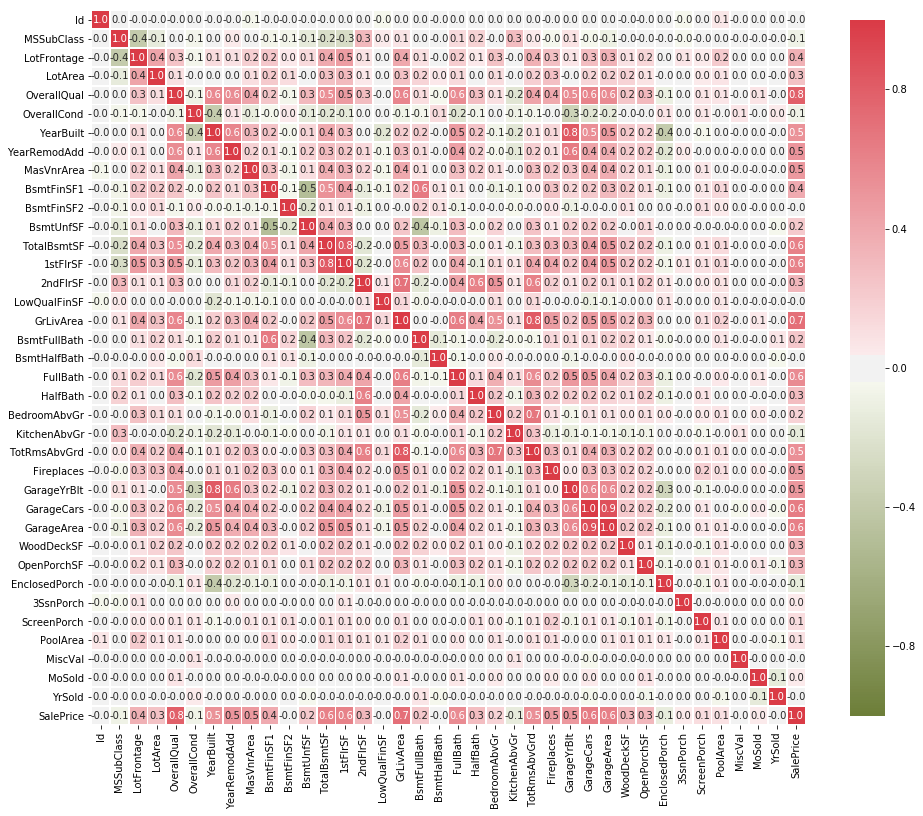

In [7]:
corr_mat = df_train.corr()

fig, ax = plt.subplots(figsize = (16, 16))

cmap = sns.diverging_palette(100, 10, as_cmap = True)
sns.heatmap(corr_mat, vmin = -1, vmax = 1, cmap = cmap,
            square=True, linewidths=0.8, cbar_kws = {'shrink': 0.8}, annot = True, fmt = '.1f')

plt.show()

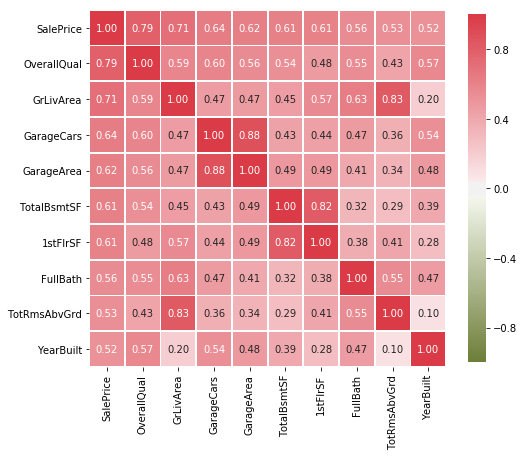

In [8]:
gd_res = corr_mat.nlargest(10, 'SalePrice')['SalePrice'].index

corr_mat2 = np.corrcoef(df_train[gd_res].values.T)

plt.subplots(figsize = (8,8))

f = sns.heatmap(corr_mat2, vmin = -1, vmax = 1, cmap = cmap,
            square=True, linewidths=0.8, cbar_kws = {'shrink': 0.8}, annot = True, fmt = '.2f',
               xticklabels = gd_res, yticklabels = gd_res)

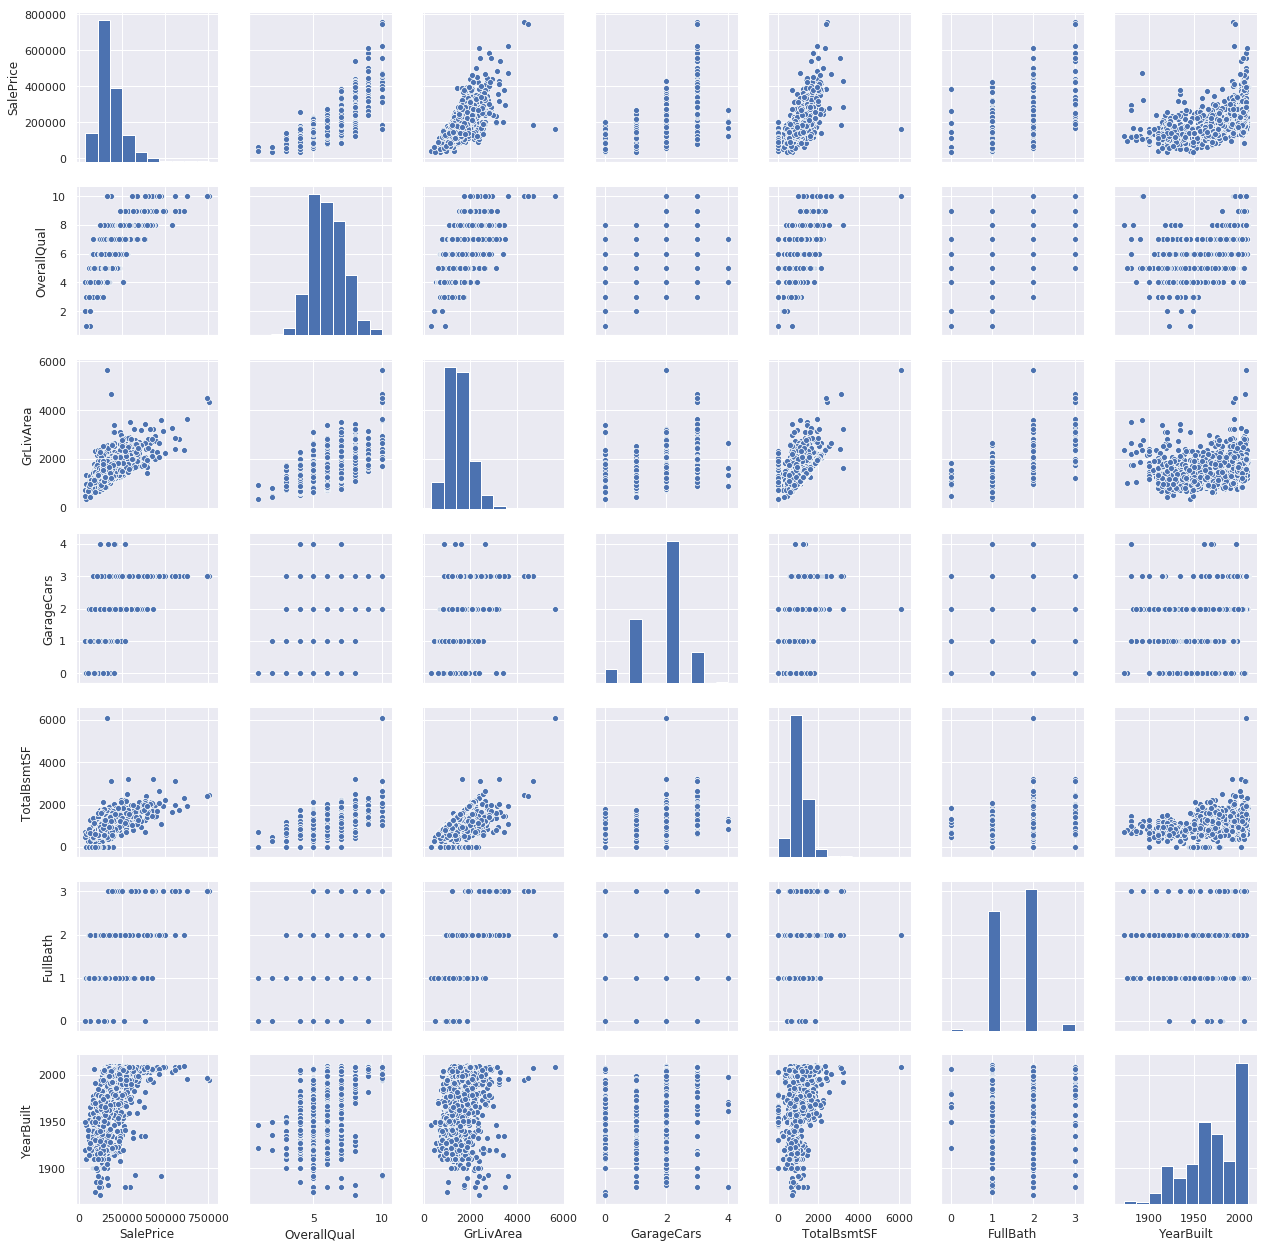

In [9]:
best_cors = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

sns.set()
sns.pairplot(df_train[best_cors])
plt.show()

### Looking for outliers 

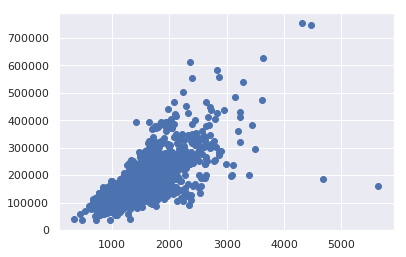

In [10]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.show()

In [11]:
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000.) & (df_train['SalePrice'] < 300000.)].index)

### Dealing with missing values

In [12]:
df = pd.concat([df_train.loc[:, 'MSSubClass': 'SaleCondition'], df_test.loc[:, 'MSSubClass': 'SaleCondition']],
               axis = 0)

In [13]:
mis_val = df.isnull().sum().sort_values(ascending = False)

mis_val_perc = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False) * 100.

In [14]:
missing_values = pd.concat([mis_val, mis_val_perc], axis = 1, keys = ['Total', 'Percent'])

miss_val_df = pd.DataFrame(mis_val_perc, columns = ['Percent'])

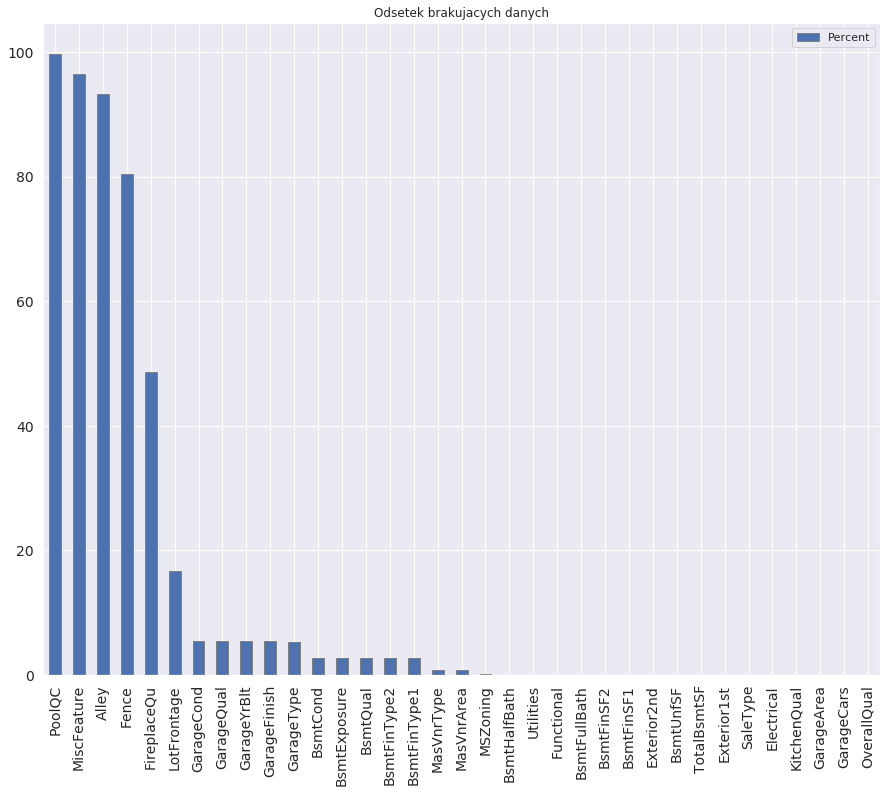

In [15]:
ax = miss_val_df[:35].plot(kind = 'bar', figsize = (15, 12), title = 'Odsetek brakujacych danych',
                fontsize = 14, edgecolor = 'grey')

In [16]:
for col in ['GarageCars', 'Utilities']:
    df.drop(col, axis = 1, inplace = True)

In [17]:
for col in ['MSZoning', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Electrical',
           'Functional']:
    df[col] = df[col].fillna(df[col].mode()[0])

In [18]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [19]:
for col in ['PoolQC', 'FireplaceQu', 'MiscFeature', 'Alley', 'Fence', 'GarageQual', 'GarageYrBlt', 'GarageFinish', 'GarageCond',
           'GarageType', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']:
    df[col] = df[col].fillna('None')

In [20]:
for col in ['GarageArea', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']:
    df[col] = df[col].fillna(0)

### Transforming some numerical features that are categorical

In [21]:
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

### Adding extra feature

In [22]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

### Dealing with skewed features

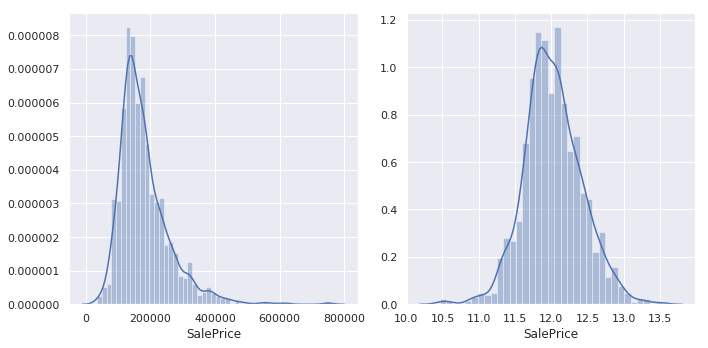

In [23]:
plt.subplots(figsize = (10, 5))

plt.subplot(121)
sns.distplot(df_train['SalePrice'])

plt.subplot(122)
sns.distplot(np.log1p(df_train['SalePrice']))

plt.tight_layout()
plt.show()

In [24]:
num_feats = df.dtypes[df.dtypes != 'object'].index

In [25]:
skew_feats = df[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)

skew_feats = skew_feats[skew_feats > 0.75].index

df[skew_feats] = np.log1p(df[skew_feats])


In [26]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

### Getting dummy features

In [27]:
df = pd.get_dummies(df, drop_first = True)

### Getting new train and test data sets

In [28]:
n_train = df_train.shape[0]

train = df[:n_train]
test = df[n_train:]
y = df_train['SalePrice']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)

### Standarizing data

In [30]:
sc = StandardScaler()

X_train.loc[:, num_feats] = sc.fit_transform(X_train.loc[:, num_feats])
X_test.loc[:, num_feats] = sc.transform(X_test.loc[:, num_feats])

### Defining functions that use analytical tools

#### Defining scorer which will be R^2 score

In [31]:
scorer = make_scorer(r2_score, greater_is_better = True )

#### Using GridSearch to find best parameters for estimators

In [32]:
def best_params(estimator, param_grid, X, y):
        
    gs = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = scorer, n_jobs = -1, cv = 10)
    gs.fit(X, y)
    
    print('R^2 best score: ', gs.best_score_)
    print('Best parameters: ', gs.best_params_)

#### Learning curve will show if our model have a problem with over- or underfitting

In [33]:
def plot_lc(estimator, X, y, title):
    
    train_sizes, train_scores, test_scores = learning_curve(estimator = estimator, X = X, y = y,
                                                            train_sizes = np.linspace(0.1, 1., 10),
                                                            cv = 10, n_jobs = 1, scoring = scorer)
    
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    
    plt.figure(figsize = (8, 6))
    plt.plot(train_sizes, train_mean, label = 'Training R^2', color = 'blue', marker = 'o')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, color = 'blue', alpha = 0.15)
    plt.plot(train_sizes, test_mean, label = 'Validation R^2', color = 'red', marker = 's')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color = 'red', alpha = 0.15) 
    
    plt.xlabel('Amount of training samples')
    plt.ylabel('R^2')
    plt.title('Learning curve for ' + title, fontsize = 14)
    plt.grid()
    plt.legend()
    plt.show()

#### With residual graph we are able to judge a performance of our model and check outliers 

In [34]:
def residual_graph(y_trn_pred, y_tst_pred, title):
    
    plt.figure(figsize = (8, 6))  
    
    plt.scatter(y_trn_pred, y_trn_pred - y_train,
           c = 'blue', marker = 'o', label = 'Training data')
    plt.scatter(y_tst_pred, y_tst_pred - y_test,
           c = 'red', marker = 's', label = 'Testing data')
    plt.hlines(y=0, xmin = 10.5, xmax = 13.5)
    
    plt.xlabel('Predicted values')
    plt.ylabel('Residual values')
    plt.title('Residual graph for ' + title, fontsize = 14)
    plt.legend(loc = 'upper right')
    plt.show()

#### Results comparision

In [35]:
def mean_scores(model):
    
    plt.figure(figsize = (10, 8))
    
    for (key, value) in models.items():
        mean_scores = np.mean(cross_val_score(value, X_train, y_train, scoring = scorer, cv = 10, n_jobs = -1))
        
        print('R^2 for ' + key + ' : %.3f' % (mean_scores))
        plt.bar(key, mean_scores)
        
    plt.ylim(0.75, 1.)
    plt.xlabel('Models')
    plt.ylabel('R^2 score')
    plt.legend()
    plt.show()

### Testing some models

#### Elastic Net 

In [36]:
en = ElasticNet(alpha = 0.001, l1_ratio = 0.7)
en.fit(X_train, y_train)
y_train_pred_en = en.predict(X_train)
y_test_pred_en = en.predict(X_test)

##### Preparing parameters grid

In [37]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_range_2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]

param_grid = [{'l1_ratio' : param_range_2, 'alpha' : param_range}]
param_grid_2 = [{'epsilon' : param_range, 'C' : param_range, 'gamma' : param_range, 'degree' : [1, 2, 3, 4]}]
param_grid_3 = [{'learning_rate' : [0.1, 0.3, 0.5, 0.8, 1.], 'n_estimators' : [10, 50, 200, 500, 1000], 'max_depth' : [3, 4, 5, 6]}]

In [38]:
#best_params(en, param_grid, X_train, y_train)

In [39]:
print('Slope %.3f' % en.coef_[0])
print('Interception point %.3f' % en.intercept_)

Slope 0.000
Interception point 11.808


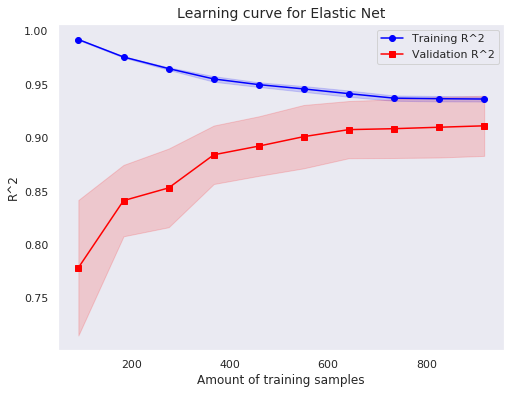

In [40]:
plot_lc(en, X_train, y_train, 'Elastic Net')

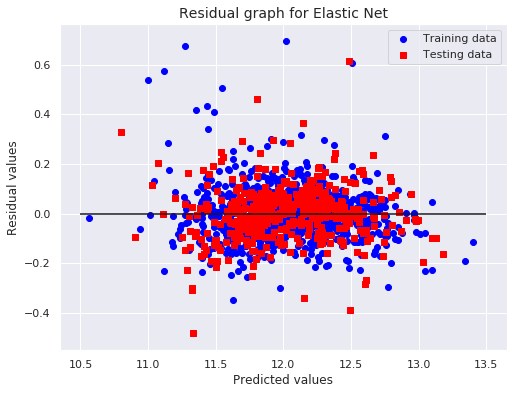

In [41]:
residual_graph(y_train_pred_en, y_test_pred_en, 'Elastic Net')

#### SVR

In [42]:
svr = SVR(C = 10.0, epsilon = 0.01, gamma = 0.001, degree = 1)
svr.fit(X_train, y_train)
y_train_pred_svr = svr.predict(X_train)
y_test_pred_svr = svr.predict(X_test)

In [43]:
#best_params(svr, param_grid_2, X_train, y_train)

In [44]:
print('Interception point %.3f' % svr.intercept_)

Interception point 12.751


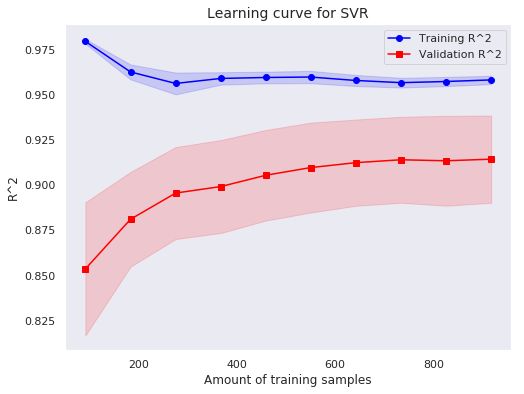

In [45]:
plot_lc(svr, X_train, y_train, 'SVR')

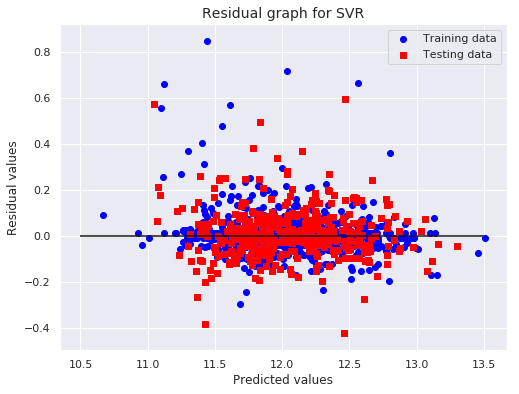

In [46]:
residual_graph(y_train_pred_svr, y_test_pred_svr, 'SVR')

#### Gradient Boosting Regressor

In [47]:
gbr = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 3, n_estimators = 500)

gbr.fit(X_train, y_train)
y_train_pred_gbr = gbr.predict(X_train)
y_test_pred_gbr = gbr.predict(X_test)

In [48]:
#best_params(gbr, param_grid_3, X_train, y_train)

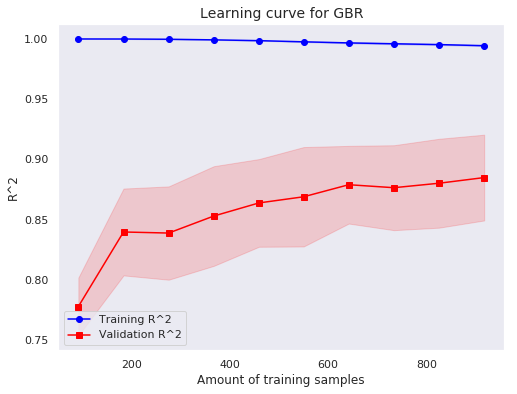

In [49]:
plot_lc(gbr, X_train, y_train, 'GBR')

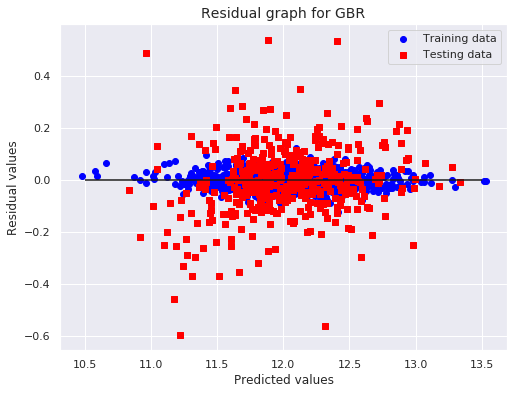

In [50]:
residual_graph(y_train_pred_gbr, y_test_pred_gbr, 'GBR')

### Plotting results

In [51]:
models = {'Elastic Net' : en, 'Support Vector Regression' : svr, 'Gradient boosting Regressor' : gbr}

R^2 for Elastic Net : 0.912
R^2 for Support Vector Regression : 0.914


No handles with labels found to put in legend.


R^2 for Gradient boosting Regressor : 0.884


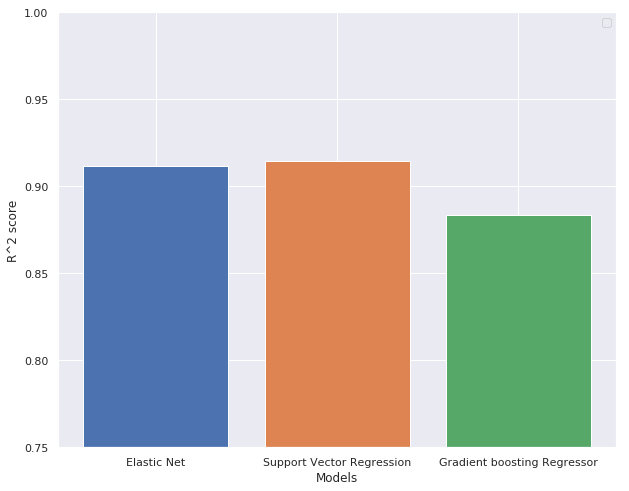

In [52]:
mean_scores(models)

### Final prediction for test data

#### Standarizing final train and test data sets

In [53]:
train.loc[:, num_feats] = sc.fit_transform(train.loc[:, num_feats])
test.loc[:, num_feats] = sc.transform(test.loc[:, num_feats])

In [56]:
svr = SVR(C = 10.0, epsilon = 0.01, gamma = 0.001, degree = 1)
svr.fit(train, y)

y_test_pred_svr = np.expm1(svr.predict(test))

### Submission

In [57]:
submission = pd.DataFrame({'id' : df_test['Id'], 'SalePrice' : y_test_pred_svr})

submission.to_csv('house_price_submission.csv', index = None)